In [1]:
import json
from networkx.readwrite import json_graph

def read_graph_from_json(json_file):
    with open(json_file) as f:
        data = json.load(f)
    return json_graph.adjacency_graph(data) 

In [2]:
# Read Oklahoma county graph from the json file "OK_county.json"
filepath = 'districting-data\\'
filename = 'OK_county.json'

G = read_graph_from_json( filepath + filename )

In [3]:
# For each node, print the node #, county name, population, and lat-long coordinates
for node in G.nodes:
    name = G.nodes[node]["NAME20"]
    population = G.nodes[node]['P0010001']
    G.nodes[node]['TOTPOP'] = population
    
    # query lat and long coordinates 
    G.nodes[node]['C_X'] = G.nodes[node]['INTPTLON20']  # longitude of county's center
    G.nodes[node]['C_Y'] = G.nodes[node]['INTPTLAT20']  # latitude of county's center
        
    print("Node",node,"is",name,"County, which has population",population,"and is centered at (",G.nodes[node]['C_X'],",",G.nodes[node]['C_Y'],")")

Node 0 is Washita County, which has population 10924 and is centered at ( -098.9914359 , +35.2894967 )
Node 1 is Jackson County, which has population 24785 and is centered at ( -099.4122347 , +34.5940059 )
Node 2 is Major County, which has population 7782 and is centered at ( -098.5420147 , +36.3131189 )
Node 3 is Delaware County, which has population 40397 and is centered at ( -094.8081892 , +36.3934371 )
Node 4 is Custer County, which has population 28513 and is centered at ( -098.9973857 , +35.6456012 )
Node 5 is Ellis County, which has population 3749 and is centered at ( -099.7501388 , +36.2242576 )
Node 6 is Oklahoma County, which has population 796292 and is centered at ( -097.4094007 , +35.5546109 )
Node 7 is Johnston County, which has population 10272 and is centered at ( -096.6542545 , +34.3134553 )
Node 8 is Comanche County, which has population 121125 and is centered at ( -098.4765859 , +34.6626252 )
Node 9 is Pushmataha County, which has population 10812 and is centered at

In [4]:
#pip install geopy

In [5]:
# what is the "distance" between Payne County (node 0), Oklahoma County (node 15), and Tulsa County (node 23)?
from geopy.distance import geodesic

# Store centroid location as ( lat, long )
Payne = ( G.nodes[42]['C_Y'], G.nodes[42]['C_X'] )
Oklahoma = ( G.nodes[6]['C_Y'], G.nodes[6]['C_X'] )
Tulsa = ( G.nodes[34]['C_Y'], G.nodes[34]['C_X'] )

# Print the distance in miles
print("Payne -> Oklahoma:", geodesic(Payne, Oklahoma).miles )
print("Oklahoma -> Tulsa:", geodesic(Oklahoma, Tulsa).miles )
print("Tulsa -> Payne:", geodesic(Tulsa, Payne).miles )

Payne -> Oklahoma: 43.618255585197396
Oklahoma -> Tulsa: 91.1540938016197
Tulsa -> Payne: 57.89479056828953


In [6]:
# create distance dictionary
dist = { (i,j) : 0 for i in G.nodes for j in G.nodes }
for i in G.nodes:
    for j in G.nodes:
        loc_i = ( G.nodes[i]['C_Y'], G.nodes[i]['C_X'] )
        loc_j = ( G.nodes[j]['C_Y'], G.nodes[j]['C_X'] )
        dist[i,j] = geodesic(loc_i,loc_j).miles

In [7]:
# check the dictionary by printing the Payne County -> Oklahoma County distance
print("Payne -> Oklahoma:",dist[42,6])

Payne -> Oklahoma: 43.618255585197396


In [8]:
# Let's impose a 2% population deviation (+/-1%)
deviation = 0.02

import math
k = 5          # number of districts
total_population = sum( G.nodes[node]['TOTPOP'] for node in G.nodes)

L = math.ceil( ( 1 - deviation / 2 ) * total_population / k )
U = math.floor( ( 1 + deviation / 2 ) * total_population / k )
print("Using L =",L,"and U =",U,"and k =",k)

Using L = 783952 and U = 799789 and k = 5


In [9]:
import gurobipy as gp
from gurobipy import GRB

# create model 
m = gp.Model()

# create x[i,j] variable which equals one when county i 
#    is assigned to (the district centered at) county j
x = m.addVars( G.nodes, G.nodes, vtype=GRB.BINARY )

Set parameter Username
Academic license - for non-commercial use only - expires 2024-05-11


In [10]:
# objective is to minimize the moment of inertia: sum (d^2 * p * x over all i and j)
m.setObjective( gp.quicksum( dist[i,j] * dist[i,j] * G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes for j in G.nodes ), GRB.MINIMIZE )

In [11]:
# add constraints saying that each county i is assigned to one district
m.addConstrs( gp.quicksum( x[i,j] for j in G.nodes ) == 1 for i in G.nodes )

# add constraint saying there should be k district centers
m.addConstr( gp.quicksum( x[j,j] for j in G.nodes ) == k )

# add constraints that say: if j roots a district, then its population is between L and U.
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes ) >= L * x[j,j] for j in G.nodes )
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes ) <= U * x[j,j] for j in G.nodes )

# add coupling constraints saying that if i is assigned to j, then j is a center.
m.addConstrs( x[i,j] <= x[j,j] for i in G.nodes for j in G.nodes )

m.update()

In [12]:
# solve, making sure to set a 0.00% MIP gap tolerance
m.Params.MIPGap = 0.0

m.optimize()

Set parameter MIPGap to value 0
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i7-4790 CPU @ 3.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 6161 rows, 5929 columns and 29568 nonzeros
Model fingerprint: 0xda2784b7
Variable types: 0 continuous, 5929 integer (5929 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+05]
  Objective range  [1e+06, 9e+10]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 313 rows and 148 columns
Presolve time: 0.09s
Presolved: 5848 rows, 5781 columns, 29359 nonzeros
Variable types: 0 continuous, 5781 integer (5781 binary)

Root relaxation: objective 8.285528e+09, 2196 iterations, 0.32 seconds (0.52 work units)

    Nodes    |    Current Node    |     Objective Bounds      |    

In [13]:
# print the objective value
print(m.objVal)

# retrieve the districts and their populations
#    but first get the district "centers"

centers = [ j for j in G.nodes if x[j,j].x > 0.5 ]

districts = [ [ i for i in G.nodes if x[i,j].x > 0.5 ] for j in centers ]
district_counties = [ [ G.nodes[i]["NAME20"] for i in districts[j] ] for j in range(k)]
district_populations = [ sum(G.nodes[i]["TOTPOP"] for i in districts[j]) for j in range(k) ]

# print district info
for j in range(k):
    print("District",j,"has population",district_populations[j],"and contains counties",district_counties[j])
    print("")

8408524436.390146
District 0 has population 796292 and contains counties ['Oklahoma']

District 1 has population 794911 and contains counties ['Johnston', 'Comanche', 'Cleveland', 'Garvin', 'Tillman', 'Jefferson', 'Bryan', 'Stephens', 'Murray', 'Marshall', 'Carter', 'Cotton', 'Atoka', 'Seminole', 'Pontotoc', 'Pottawatomie', 'Love']

District 2 has population 790979 and contains counties ['Craig', 'Osage', 'Tulsa', 'Nowata', 'Washington']

District 3 has population 792948 and contains counties ['Washita', 'Jackson', 'Major', 'Custer', 'Ellis', 'Beckham', 'Logan', 'Pawnee', 'McClain', 'Beaver', 'Dewey', 'Roger Mills', 'Texas', 'Woodward', 'Kingfisher', 'Grant', 'Grady', 'Payne', 'Cimarron', 'Garfield', 'Canadian', 'Harper', 'Alfalfa', 'Lincoln', 'Caddo', 'Greer', 'Woods', 'Harmon', 'Kay', 'Blaine', 'Kiowa', 'Noble']

District 4 has population 784223 and contains counties ['Delaware', 'Pushmataha', 'Wagoner', 'Cherokee', 'Pittsburg', 'Okfuskee', 'Le Flore', 'Choctaw', 'Latimer', 'McIntosh

In [14]:
# Let's draw it on a map
import geopandas as gpd

In [15]:
# Read Oklahoma county shapefile from "OK_county.shp"
filepath = 'districting-data\\'
filename = 'OK_county.shp'

# Read geopandas dataframe from file
df = gpd.read_file( filepath + filename )

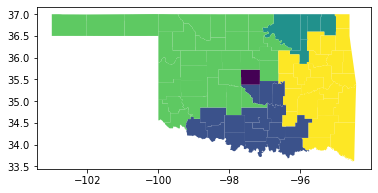

In [16]:
# Which district is each county assigned to?
assignment = [ -1 for i in G.nodes ]

labeling = { i : -1 for i in G.nodes }
for j in range(k):
    district = districts[j]
    for i in district:
        labeling[i] = j

# Now add the assignments to a column of the dataframe and map it
node_with_this_geoid = { G.nodes[i]['GEOID20'] : i for i in G.nodes }

# pick a position u in the dataframe
for u in range(G.number_of_nodes()):
    
    geoid = df['GEOID20'][u]
    
    # what node in G has this geoid?
    i = node_with_this_geoid[geoid]
    
    # position u in the dataframe should be given
    # the same district # that county i has in 'labeling'
    assignment[u] = labeling[i]
    
# now add the assignments to a column of our dataframe and then map it
df['assignment'] = assignment

my_fig = df.plot(column='assignment').get_figure()